## CNN para previsão de fraturas

**Acerca do Dataset**
- Este conjunto de dados é composto por imagens de raios X fraturadas e não fraturadas de várias articulações. A tarefa é construir um classificador de imagens para detectar fraturas em determinada imagem de raio-X. Este conjunto de dados é composto por diferentes articulações nas extremidades superiores. O isolamento de articulações individuais é recomendado para melhorar o desempenho dos classificadores.
- 8863 instâncias para treino
- 600 instâncias para teste

### Imports

In [1]:
!pip install livelossplot
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.5 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from livelossplot import PlotLosses

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

from torchvision.datasets import ImageFolder

from monai.networks.nets import EfficientNetBN

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Resize
from torchvision.transforms import Grayscale

2024-05-06 10:58:19.666646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 10:58:19.666772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 10:58:19.797468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 0. Preparar o Setup

In [3]:
PATH_TRAIN = '/kaggle/input/archive (6)/train'
PATH_TEST = '/kaggle/input/archive (6)/val'

BATCH_SIZE = 32

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


### 1. Preparar os dados

In [5]:
transform = Compose(
        [ToTensor(),
         #Grayscale(num_output_channels=1), 
         Resize((224, 224),antialias=True),
         Normalize(mean=(0.1307,), std=(0.3081,))  # Normaliza as imagens
        ])

In [6]:
# Definir a seed

seed = 2024

torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Importar dataset
train_dataset = ImageFolder(PATH_TRAIN, transform=transform)
test_dataset = ImageFolder(PATH_TEST, transform=transform)

validation_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

### 2. Definir o Modelo

In [7]:
model = EfficientNetBN('efficientnet-b0', num_classes=2)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 189MB/s]


In [8]:
model.to(device)

EfficientNetBN(
  (_conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_conv_stem_padding): ConstantPad2d(padding=(0, 1, 0, 1), value=0.0)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (_blocks): Sequential(
    (0): Sequential(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_expand_conv_padding): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (_depthwise_conv_padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (_se_adaptpool): AdaptiveAvgPool2d(output_size=1)
        (_se_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (_se_reduce_padding): Identity()
        (_se_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (_se_expand_padding): Identity()
        (

In [9]:
# função de perda e otimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

### 3. Treinar o Modelo

In [10]:
EPOCHS = 10

def train_model(train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float()/len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()


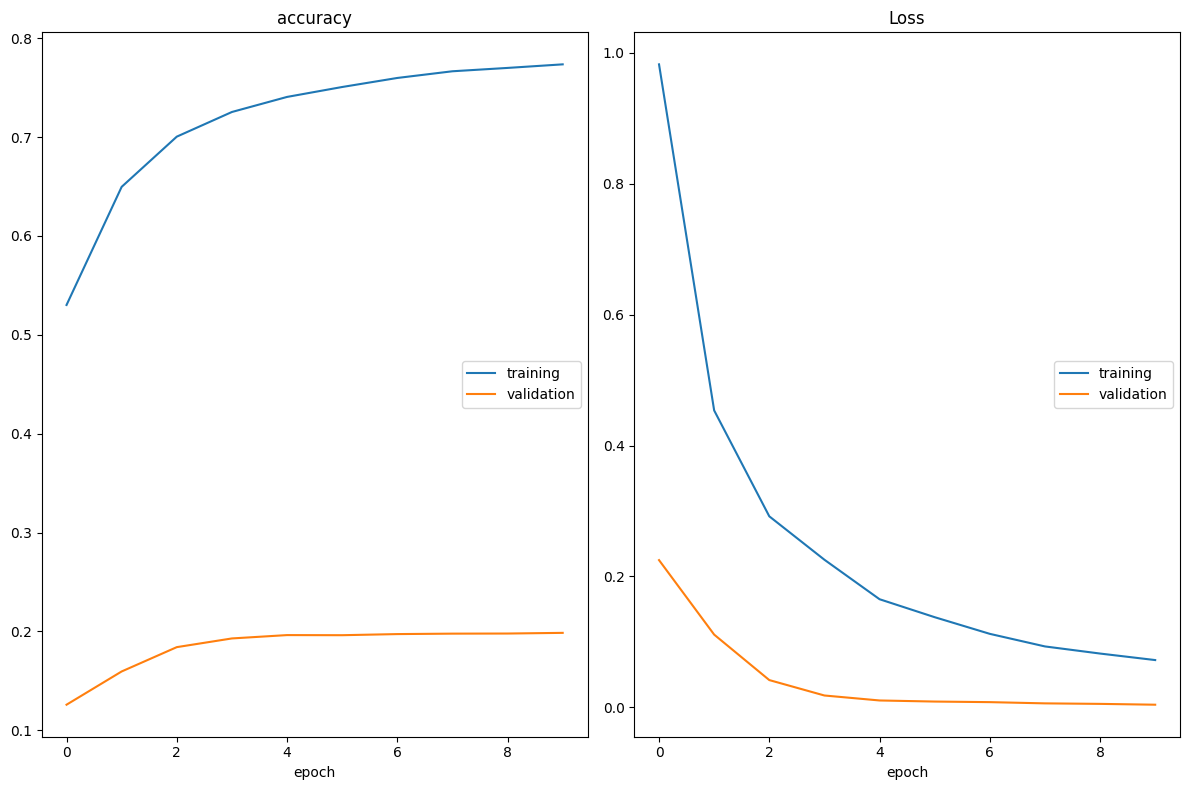

accuracy
	training         	 (min:    0.530, max:    0.774, cur:    0.774)
	validation       	 (min:    0.126, max:    0.199, cur:    0.199)
Loss
	training         	 (min:    0.072, max:    0.983, cur:    0.072)
	validation       	 (min:    0.004, max:    0.225, cur:    0.004)

Training completed in 429.41943883895874 seconds


In [11]:
start_time = time.time()

train_model(train_loader, val_loader, model, criterion, optimizer)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time} seconds")

### 4. Avaliar o modelo

In [12]:
def logits_to_probabilities(logits):
    # logits é uma matriz de formato (n_samples, n_classes)
    # onde n_samples é o número de amostras e n_classes é o número de classes
    exp_logits = np.exp(logits)  # Aplicar exponencial a cada elemento dos logits
    probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probabilities

def write_probabilities_to_csv(probabilities, filename):
    np.savetxt(filename, probabilities, delimiter=',', fmt='%.6f')

def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    device = next(model.parameters()).device
    
    model.eval()  # Garantir que o modelo está no modo de avaliação
    
    with torch.no_grad():  # Desativar o cálculo de gradientes durante a avaliação
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            yprev = model(inputs)
            yprev = yprev.detach().cpu().numpy()
            actual = labels.cpu().numpy()
            
            probabilities = logits_to_probabilities(yprev)
            write_probabilities_to_csv(probabilities, '/kaggle/working/probabilities.csv')
            
            yprev = np.argmax(yprev, axis=1)
            actual = actual.reshape((len(actual), 1))
            yprev = yprev.reshape((len(yprev), 1))
            predictions.append(yprev)
            actual_values.append(actual)
            
    predictions = np.vstack(predictions)
    actual_values = np.vstack(actual_values)
    
    return actual_values, predictions

In [13]:
def display_predictions(actual_values, predictions):
    acertou = 0
    falhou = 0
    primeiros = 0
    for r, p in zip(actual_values, predictions):
        if primeiros < 20:
            print(f'real:{r} previsão:{p}')
            primeiros += 1
        if r == p:
            acertou += 1
        else:
            falhou += 1
    
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

In [14]:
def display_confusion_matrix(cm, list_classes):
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, xticklabels=list_classes, yticklabels=list_classes, annot_kws={"size": 12},
                fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [15]:
actual_values, predictions = evaluate_model(test_loader, model)
display_predictions(actual_values, predictions)

real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[0]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[1]
real:[0] previsão:[0]
Accuracy: 0.793

acertou:476 falhou:124


In [16]:
print(classification_report(actual_values, predictions))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       360
           1       0.71      0.81      0.76       240

    accuracy                           0.79       600
   macro avg       0.79      0.80      0.79       600
weighted avg       0.80      0.79      0.79       600



In [17]:
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=['fratured', 'not fractured']
cm = confusion_matrix(actual_values, predictions)
print (cm)

[[282  78]
 [ 46 194]]


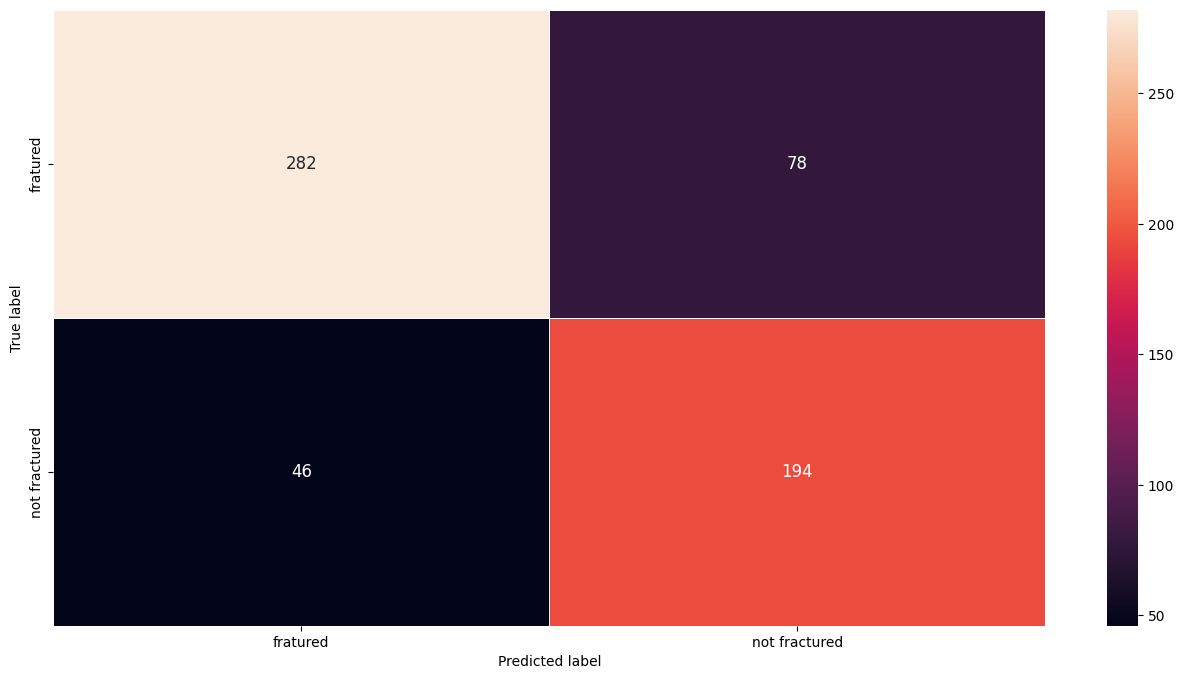

In [18]:
display_confusion_matrix(cm,list_classes)

### 5. Guardar o Modelo

In [19]:
torch.save(model.state_dict(), '/kaggle/working/model_efficientnet.pth')

!ls /kaggle/working

model_efficientnet.pth	probabilities.csv
